# Multi-class QSVM implementation for MNIST Classification

This notebook implements a multi-class QSVM for classifying handwritten digits using D-Wave's quantum annealing hardware.

The implementation combines classical machine learning techniques with quantum optimization to experiment on an hybrid quantum-classical pipeline definition and usage, exploiting a multi-class instance of the problem defined in `qsvm-binary.ipynb` to further push the capabilities of the JUNIQ and Ocean-DWAVE platforms.

NOTE: this implementation instance distances itself from the binary one, as, for convenience reasons, a partial rewriting of the general workflow was practically more convenient than re-adaptation of the other one.

---

## Problem Overview


#### **SVMs**
Classical Support Vector Machines (SVMs) work by finding an optimal hyperplane that separates different classes in a feature space. Their associated optimization problem can be formulated as:

$$\min_{\alpha} \frac{1}{2}\sum_{i,j=1}^n \alpha_i\alpha_j y_i y_j K(x_i,x_j) - \sum_{i=1}^n \alpha_i$$

subject to:
$$0 \leq \alpha_i \leq C, \quad \sum_{i=1}^n \alpha_i y_i = 0$$

where:
- $\alpha_i$ are the Lagrange multipliers;
- $y_i$ are class labels (±1);
- $K(x_i,x_j)$ is the kernel function;
- $C$ is the regularization parameter.


#### **QUBO**
We reformulate this as a Quadratic Unconstrained Binary Optimization (QUBO) problem suitable for D-Wave's quantum annealer:

$$\min_{s \in \{0,1\}^n} s^T Q s$$

where $Q$ encodes both the objective function and constraints.


#### **Quantum Annealing**

Then, this formulation is fed to the quantum annealer, that finds the minimum energy state corresponding to the optimal solution by adiabatically evolving the initial ground state according to the problem Hamiltonian.

Specifically, the quantum annealing process evolves the system according to the Hamiltonian:

$$H(t) = A(t)H_0 + B(t)H_P$$

where:
- $H_0$ is the initial Hamiltonian
- $H_P$ is the problem Hamiltonian (encoding our QUBO)
- $A(t), B(t)$ are annealing schedules with $t \in [0,T]$


#### **Multi-class generalization**

The one-vs-all approach trains multiple binary classifiers. In general, for class $k$, this approach involves:

1. **Label Transformation**: 
   $$y_i^{(k)} = \begin{cases} 
   +1 & \text{if class } = k \\
   -1 & \text{otherwise}
   \end{cases}$$

2. **Probability Estimation**: using sigmoid function:
   $$P(y=k|x) = \frac{1}{1 + e^{-f_k(x)}}$$
   where $f_k(x)$ is the decision function for class $k$.

3. **Final Classification**: 
   $$\text{class} = \arg\max_k P(y=k|x)$$


References:
- Willsch, D., et al. (2020). "Support Vector Machines on the D-Wave Quantum Annealer" [DOI:10.1016/j.cpc.2020.107006]
- Neven, H., et al. (2012). "Training a Large Scale Classifier with the Quantum Adiabatic Algorithm" [arXiv:0912.0779]
- Rebentrost, P., et al. (2014). "Quantum Support Vector Machine for Big Data Classification" [Physical Review Letters](https://doi.org/10.1103/PhysRevLett.113.130503)


---

## Implementation Strategy

Therefore, our project implementations will realize each of the above structure through the following steps: 

1. **Dataset Preprocessing**: preparation of embedding for MNIST digits from `sklearn`

2. **Problem formulation**:
    1. **QUBO Formulation**: create quantum-annealing-compatible optimization problem
    2. **Quantum Annealing**: embed and solve on D-Wave hardware
    3. **Multi-class Extension**: one-vs-all approach for all digits
    
3. **Training**: instantiate training pipeline with (fixed) hyperparams
4. **Evaluation**: plots and stuff

For each point, dedicated subsection will expand the discussion on how one such problem is encoded, reformulated for our purposes and implemented.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, preprocessing
from sklearn.model_selection import train_test_split

# D-Wave Ocean SDK importsc
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod

# custom utilities
from utils import (kernel, eval_classifier, eval_offset_avg, 
                  eval_acc_auroc_auprc, write_samples)

%matplotlib inline

---

### 1. Dataset preprocessing

Since we are working with a well-known, well-behaved dataset from `sklearn`, no particular cleaning and engineering of features is needed on the dataset itself. Still, some rearranging is need to have the final model better conditioned, but, most importantly, to have a problem instance that can be somewhat easily be run on our cloud-based platform.

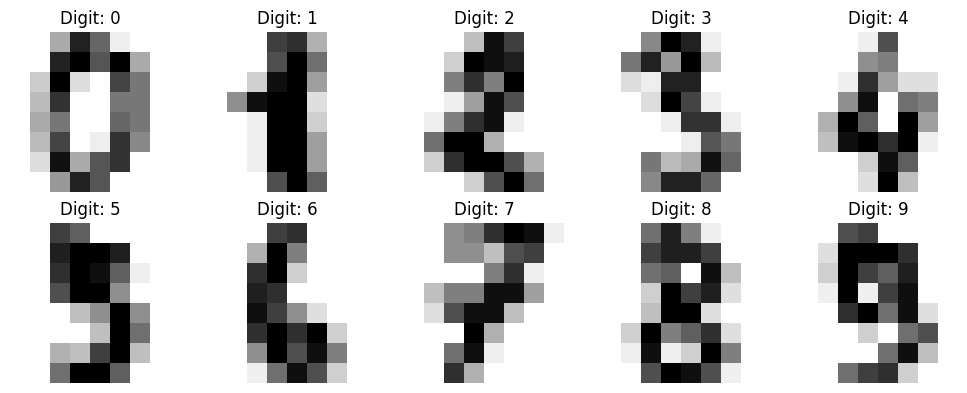

In [ ]:
# Load MNIST dataset
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, img, label in zip(axes.ravel(), digits.images[:10], digits.target[:10]):
    ax.imshow(img, cmap=plt.cm.gray_r)
    ax.set_title(f'Digit: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

As mentioned above, we then perform some minor modification for both theoretical and practical reasons:

1. **Data Splitting and Scaling**

   - 70-30 train-test split with fixed random seed (42, for the memes)
   - `StandardScaler` applied to features:
     $$x'_i = \frac{x_i - \mu_i}{\sigma_i}$$
   - Scaling parameters learned only from training data

In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# scale features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

2. **Mini-batch Creation Strategy**

   The `create_binary_batches` function implements balanced sampling for binary classification.
   
   This is particularly relevant in our case as the multi-class instance is based on the **One-vs-All** premise, where we combine multiple binary classifiers of the target digit class and the 'everything else' class.
   
   In addition, balanced classes are created, to once again improve conditioning of the model.
   
   Finally, we explicitly hardcode an experimentally-derived working batch size so as not to overload our API calls to the quantum hardware, which would otherwise be unfeasible to run on the available infrastructure. In this regard, the mini-batch strategy helps manage the QUBO size, as the number of binary variables scales as $O(NK)$ where:
      - $N$ is the batch size
      - $K$ is the number of bits used to encode each $\alpha_i$

      This approach is crucial because the quantum annealer's resources are limited by:
      1. Number of available qubits.
      2. Qubit connectivity graph.
      3. Precision of coupling strengths.
   
   Therefore, our function

   - for each digit $d$, creates batches where:
     $$y = \begin{cases} +1 & \text{for digit }d \\ -1 & \text{for other digits} \end{cases}$$
   - each batch contains equal numbers of positive and negative examples;
   - random sampling without replacement ensures diverse batches;
   - batch size (40) optimized for fitting our QUBO within the D-Wave quantum processor constraints while maintaining sufficient training signal.

In [ ]:
def create_binary_batches(X, y, positive_digit, batch_size=40):

    """Create balanced batches for binary classification of one digit vs rest."""

    pos_idx = (y == positive_digit)
    neg_idx = ~pos_idx
    
    # convert to binary labels (+1 for positive class, -1 for others)
    y_binary = np.where(pos_idx, 1, -1)
    
    # calculate samples per class (half batch size for each)
    n_per_class = batch_size // 2
    
    # get indices for positive and negative samples
    pos_indices = np.where(pos_idx)[0]
    neg_indices = np.where(neg_idx)[0]
    
    # create batches
    n_batches = min(len(pos_indices), len(neg_indices)) // n_per_class
    batches = []
    
    for i in range(n_batches):
        pos_batch = np.random.choice(pos_indices, n_per_class, replace=False)
        neg_batch = np.random.choice(neg_indices, n_per_class, replace=False)
        
        batch_indices = np.concatenate([pos_batch, neg_batch])
        batches.append((X[batch_indices], y_binary[batch_indices]))
    
    return batches

Having defined the major preprocessing steps, we construct the data preparation pipeline according to the standard procedure, i.e., by including

#### **Stratified Sampling**

Stratified sampling ensures proper class representation across splits. For a dataset with $C$ classes, we maintain:

$$\frac{n_c^{train}}{N_{train}} \approx \frac{n_c^{val}}{N_{val}} \approx \frac{n_c^{test}}{N_{test}} \approx \frac{n_c}{N}$$

where:
- $n_c$ is the number of samples in class $c$
- $N$ is the total number of samples
- Superscripts indicate the respective splits

#### **Data Standardization**

Feature standardization is crucial for SVM performance, as already discussed. For each feature $j$:

$$x'_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}$$

where $\mu_j$ and $\sigma_j$ are computed only from training data to prevent data leakage.

#### **Cross-Validation**

Using k-fold stratified cross-validation ($k=5$) ensures:
1. Robust performance estimation
2. Maintained class distributions
3. Independence between training and validation

The stratification procedure minimizes the variance in performance estimates across folds.

In [ ]:
import os
from sklearn.model_selection import StratifiedKFold

def prepare_mnist_data(test_size=0.3, random_state=42):

    """Complete data preparation pipeline for MNIST dataset."""

    # load and split
    digits = datasets.load_digits()
    X, y = digits.data, digits.target
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create validation split for hyperparameter tuning
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    train_idx, val_idx = next(skf.split(X_train_scaled, y_train))
    
    X_train_final = X_train_scaled[train_idx]
    y_train_final = y_train[train_idx]
    X_val = X_train_scaled[val_idx]
    y_val = y_train[val_idx]
    
    return {
        'train': (X_train_final, y_train_final),
        'validation': (X_val, y_val),
        'test': (X_test_scaled, y_test),
        'scaler': scaler
    }

In [ ]:
data_splits = prepare_mnist_data()
print("Dataset sizes:")
print(f"Training: {data_splits['train'][0].shape}")
print(f"Validation: {data_splits['validation'][0].shape}")
print(f"Test: {data_splits['test'][0].shape}")

Dataset sizes:
Training: (1005, 64)
Validation: (252, 64)
Test: (540, 64)


---

## 2. Problem formulation

Below, we define the `OneVsAllQSVM` class, that contains the core methods for building the problem and running the training instance. Specifically, the class contains the realization of the theoretical steps presented at the beginning of the notebook, those needed for the construction of the QUBO matrix, those for embedding into the annealers, as well as core training definitions. The methods of the class are implemented according to the following considerations:


#### **QUBO Formulation**

The SVM optimization problem is transformed into a QUBO formulation suitable for quantum annealing. The key steps are:

1. **Binary Expansion**: Each $\alpha_i$ is encoded using $K$ binary variables:
   $$\alpha_i = \sum_{k=0}^{K-1} B^k s_{ik}$$
   where $s_{ik} \in \{0,1\}$ are the quantum bits.

2. **QUBO Matrix Construction**: The QUBO matrix $Q$ has elements:
   $$Q_{nk,mj} = \frac{1}{2}B^{k+j}y_ny_m(K(x_n,x_m) + \xi) - B^k\delta_{nm}\delta_{kj}$$
   where:
   - $B$ is the base (typically 2)
   - $\xi$ is a bias term
   - $K(x_n,x_m)$ is the kernel function
   - $\delta_{nm}$ is the Kronecker delta

3. **Kernel Function**: Using RBF kernel:
   $$K(x_i,x_j) = \exp(-\gamma\|x_i-x_j\|^2)$$

Note that the definition of the subroutines called within the class methods can be found within the `utils.py` provided file.


#### **Annealing**

From the D-Wave Ocean SDK Documentation (hence the slight rewriting of the formula), we only need to know, also as already mentioned, that the quantum system evolves according to the time-dependent Hamiltonian:
$$H(s) = (1-s)H_I + sH_P$$

where where $s = t/T$ is the normalized time parameter, and:

- $H_I = -\sum_i \sigma_x^i$ (initial Hamiltonian)
- $H_P = \sum_{i,j} Q_{ij}\sigma_z^i\sigma_z^j$ (problem Hamiltonian)

The $\sigma_x$ and $\sigma_z$ are Pauli matrices representing quantum bits in the hardware.

Indeed, there is no need for us to explicitly define this behavior, as this is tied to the inner mechanics of annealing-based quantum computers. For this reason, the API just needs the QUBO matrix to be fed for a call to the QPU, and our job in regard to the problem specification is already complete.

In this regard, we will take advantage of the D-Wave Ocean SDK through the:
  * `DWaveSampler`: Direct access to quantum annealer
  * `EmbeddingComposite`: Maps problems to quantum hardware
  * `dimod`: QUBO problem formulation


#### **Multi-class generalization**

As described at the beginning, appropriate re-labeling, as well as sigmoid estimation, together with maximum likelihood classification is performed to generalize our binary classifier to a multi-class one.

NOTE: due to limited timeframes, the digits have been reduced to just 0, 1, and 2, which still allows for a multi-class generalization, while at the same time reducing the timeframe requirements for experimenting on the project.

In [ ]:
class OneVsAllQSVM:
    def __init__(self, B=2, K=3, xi=1, gamma=0.25, batch_size=40):
        self.B = B
        self.K = K
        self.xi = xi
        self.gamma = gamma
        self.batch_size = batch_size
        self.models = []  # Store trained models for each digit
        self.sampler = EmbeddingComposite(DWaveSampler())
    
    def create_qubo(self, data, labels):
        """Create QUBO formulation for binary QSVM problem."""
        N = len(data)
        Q = np.zeros((self.K*N, self.K*N))
        
        # Create QUBO matrix
        for n in range(N):
            for m in range(N):
                for k in range(self.K):
                    for j in range(self.K):
                        Q[self.K*n+k, self.K*m+j] = 0.5 * self.B**(k+j) * labels[n] * labels[m] * \
                            (kernel(data[n], data[m], self.gamma) + self.xi)
                        if n == m and k == j:
                            Q[self.K*n+k, self.K*m+j] -= self.B**k
        
        # Convert to upper triangular and extract non-zero elements
        Q = np.triu(Q) + np.tril(Q,-1).T
        qubo = {(i, j): Q[i,j] for i in range(len(Q)) for j in range(i,len(Q)) 
                if not np.isclose(Q[i,j], 0, atol=1e-5)}
        
        return qubo
    
    def solve_qubo(self, qubo, num_reads=1000):
        """Solve QUBO problem on D-Wave QPU."""
        response = self.sampler.sample_qubo(qubo, num_reads=num_reads)
        return response
    
    def decode_response(self, response, N):
        """Decode QPU response to get alphas."""
        samples = response.record.sample[:20]  # Get 20 lowest energy samples
        alphas = np.zeros((len(samples), N))
        
        for i, sample in enumerate(samples):
            for n in range(N):
                # Decode binary variables to alpha values
                alpha = sum(self.B**k * sample[self.K*n + k] for k in range(self.K))
                alphas[i,n] = alpha
                
        return np.mean(alphas, axis=0)  # Average over samples
    
    def fit_binary(self, X, y):
        """Train one binary QSVM."""

        positive_digit = 1  # Default value for positive class label
        for digit in range(2):
            if np.any(y == 1) and np.all(y[y == 1] == digit):
                positive_digit = digit
                break
        batches = create_binary_batches(X, y, positive_digit, batch_size=self.batch_size)
        all_alphas = []
        all_support_data = []
        all_support_labels = []
        
        for batch_X, batch_y in batches:
            qubo = self.create_qubo(batch_X, batch_y)
            response = self.solve_qubo(qubo)
            alphas = self.decode_response(response, len(batch_X))
            
            # Keep only support vectors (non-zero alphas)
            support_idx = ~np.isclose(alphas, 0, atol=1e-5)
            if np.any(support_idx):
                all_alphas.append(alphas[support_idx])
                all_support_data.append(batch_X[support_idx])
                all_support_labels.append(batch_y[support_idx])
        
        return (np.concatenate(all_alphas), 
                np.concatenate(all_support_data), 
                np.concatenate(all_support_labels))
        
    def fit(self, X, y):
        """Train QSVMs for 3 digits (indeed, it does classify as multi-class)"""
        self.models = []
        for digit in range(2):
            print(f"Training QSVM for digit {digit}...")
            y_binary = np.where(y == digit, 1, -1)
            model = self.fit_binary(X, y_binary)
            self.models.append(model)
        return self
    
    def predict_proba(self, X):
        """Get probability estimates for each class."""
        n_samples = len(X)
        probas = np.zeros((n_samples, 10))
        
        for digit, (alphas, sv_data, sv_labels) in enumerate(self.models):
            # Calculate decision values
            decision = eval_classifier(X, alphas, sv_data, sv_labels, self.gamma, eval_offset_avg(alphas, sv_data, sv_labels, self.gamma, self.B**self.K))
            # Convert to probabilities using sigmoid
            probas[:, digit] = 1 / (1 + np.exp(-decision))
        
        # Normalize probabilities
        probas /= probas.sum(axis=1, keepdims=True)
        return probas
    
    def predict(self, X):
        """Predict class labels."""
        return np.argmax(self.predict_proba(X), axis=1)

## 3. Training

Here, we hardcode a working batch size to have our QUBO problem fit into the chosen hardware:

   $$\text{QUBO size} = NK \times NK$$

where $N$ is batch size and $K$ is number of bits.

#### **Performance Metrics**

For multi-class classification:

1. **Accuracy**:
   $$\text{Accuracy} = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(y_i = \hat{y}_i)$$

2. **Macro F1-score**:
   $$F1_{\text{macro}} = \frac{1}{C}\sum_{c=1}^C \frac{2P_cR_c}{P_c + R_c}$$
   where $P_c$ and $R_c$ are precision and recall for class $c$

The training pipeline tracks these metrics along with computation time and quantum hardware statistics.

In [5]:
# 2. Training Pipeline with Progress Tracking
from datetime import datetime
import json

class QSVMTrainingPipeline:
    def __init__(self, save_dir='qsvm_models'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
    def train_and_save_model(self, data_splits, hyperparams=None):
        """Complete training pipeline with progress tracking and model saving."""
        if hyperparams is None:
            hyperparams = {
                'B': 2,
                'K': 3,
                'xi': 1,
                'gamma': 0.25,
                'batch_size': 40
            }
            
        # Initialize model
        model = OneVsAllQSVM(**hyperparams)
        
        # Training start time
        start_time = datetime.now()
        print(f"Starting training at {start_time}")
        
        # Train model
        X_train, y_train = data_splits['train']
        model.fit(X_train, y_train)
        
        # Calculate training time
        end_time = datetime.now()
        training_time = (end_time - start_time).total_seconds()
        
        # Evaluate on validation set
        X_val, y_val = data_splits['validation']
        val_pred = model.predict(X_val)
        val_metrics = {
            'accuracy': metrics.accuracy_score(y_val, val_pred),
            'f1_macro': metrics.f1_score(y_val, val_pred, average='macro')
        }
        
        # Save model metadata
        metadata = {
            'hyperparameters': hyperparams,
            'training_time': training_time,
            'validation_metrics': val_metrics,
            'training_date': start_time.isoformat(),
            'data_shapes': {
                'train': X_train.shape,
                'validation': X_val.shape
            }
        }
        
        # Save metadata
        metadata_path = os.path.join(self.save_dir, 'model_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
            
        print("\nTraining Summary:")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Validation accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Validation F1 (macro): {val_metrics['f1_macro']:.4f}")
        
        return model, metadata

# Initialize pipeline and train model
pipeline = QSVMTrainingPipeline()
trained_model, training_metadata = pipeline.train_and_save_model(data_splits)

Starting training at 2025-09-05 08:17:06.053014
Training QSVM for digit 0...


/tmp/ipykernel_1438/35372867.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[self.K*n+k, self.K*m+j] = 0.5 * self.B**(k+j) * labels[n] * labels[m] * \


Training QSVM for digit 1...

Training Summary:
Training time: 1403.90 seconds
Validation accuracy: 0.1944
Validation F1 (macro): 0.0969


## Model Evaluation

### Performance Metrics Theory

1. **Confusion Matrix**
   For $C$ classes, the matrix $M \in \mathbb{R}^{C \times C}$ where:
   $$M_{ij} = |\{x : \text{true}(x)=i \text{ and } \text{pred}(x)=j\}|$$

2. **ROC Analysis**
   For each binary classifier:
   - True Positive Rate: $TPR(t) = \frac{TP(t)}{P}$
   - False Positive Rate: $FPR(t) = \frac{FP(t)}{N}$
   - AUC: $\text{AUC} = \int_0^1 TPR(FPR^{-1}(f))df$

3. **Per-Class Metrics**
   For each class $c$:
   - Precision: $P_c = \frac{TP_c}{TP_c + FP_c}$
   - Recall: $R_c = \frac{TP_c}{TP_c + FN_c}$
   - F1-score: $F1_c = \frac{2P_cR_c}{P_c + R_c}$

### Multi-class Extensions

The one-vs-all approach requires aggregating binary metrics:

1. **Macro-averaging**:
   $$\text{Metric}_{\text{macro}} = \frac{1}{C}\sum_{c=1}^C \text{Metric}_c$$

2. **Micro-averaging**:
   $$\text{Metric}_{\text{micro}} = \text{Metric}(\sum_{c=1}^C TP_c, \sum_{c=1}^C FP_c, \sum_{c=1}^C FN_c)$$

These metrics provide comprehensive insight into the model's performance across all digit classes.

References:
- Fawcett, T. (2006). "An introduction to ROC analysis" [Pattern Recognition Letters](https://doi.org/10.1016/j.patrec.2005.10.010)

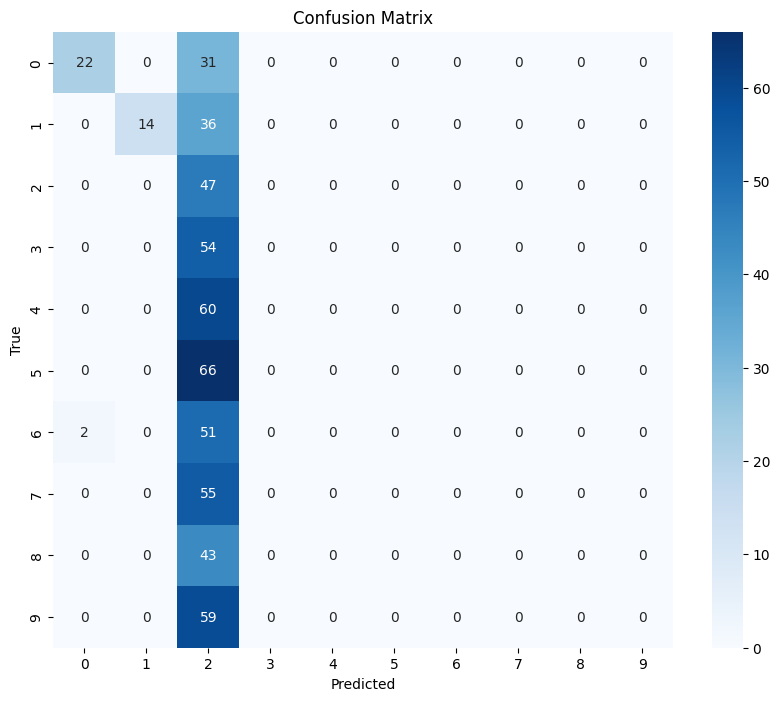

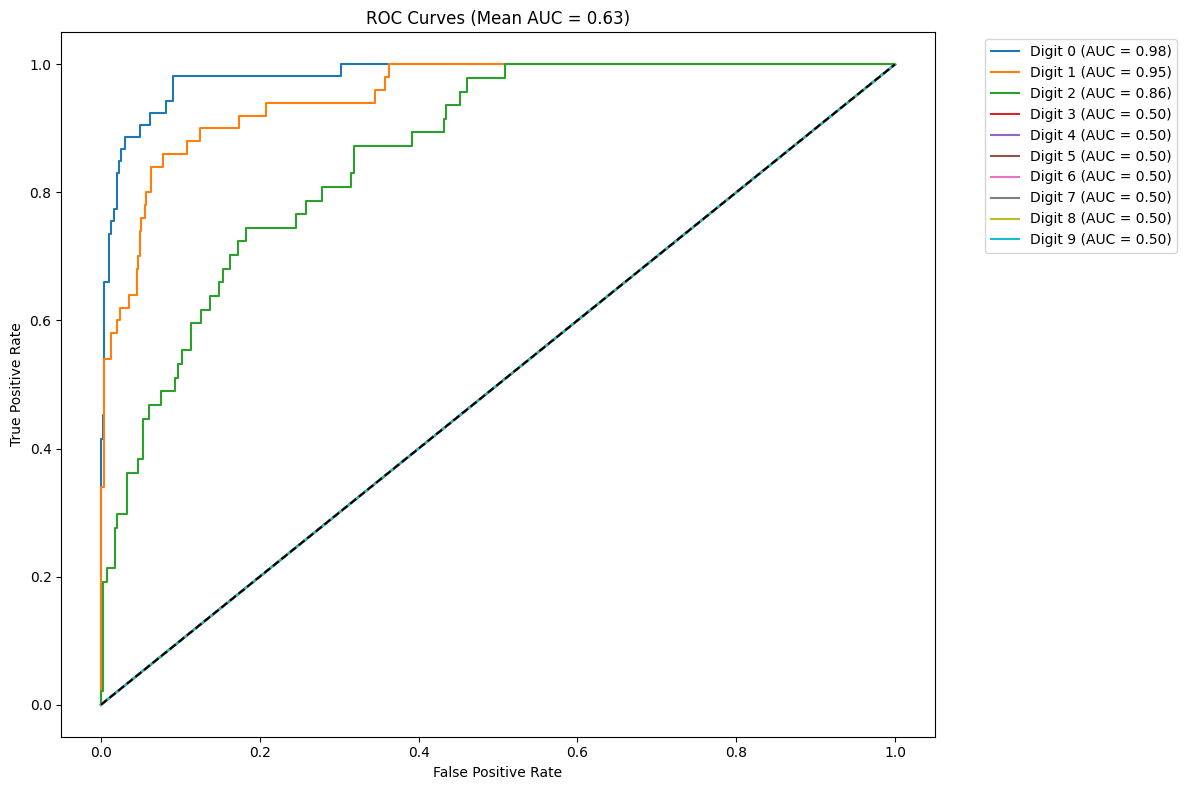


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.42      0.57        53
           1       1.00      0.28      0.44        50
           2       0.09      1.00      0.17        47
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        66
           6       0.00      0.00      0.00        53
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        43
           9       0.00      0.00      0.00        59

    accuracy                           0.15       540
   macro avg       0.20      0.17      0.12       540
weighted avg       0.19      0.15      0.11       540



/p/software/jsccloud/stages/2025/software/scikit-learn/1.5.2-gcccoreflexiblas-13.3.0-3.4.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/p/software/jsccloud/stages/2025/software/scikit-learn/1.5.2-gcccoreflexiblas-13.3.0-3.4.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/p/software/jsccloud/stages/2025/software/scikit-learn/1.5.2-gcccoreflexiblas-13.3.0-3.4.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defi

In [6]:
# 3. Comprehensive Model Evaluation
from sklearn.metrics import precision_recall_curve
import seaborn as sns

def evaluate_qsvm_model(model, data_splits):
    """Comprehensive evaluation of QSVM model performance."""
    X_test, y_test = data_splits['test']
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    mean_auc = 0
    for digit in range(10):
        y_true_binary = (y_test == digit)
        fpr, tpr, _ = metrics.roc_curve(y_true_binary, y_prob[:, digit])
        auc = metrics.auc(fpr, tpr)
        mean_auc += auc
        plt.plot(fpr, tpr, label=f'Digit {digit} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Mean AUC = {mean_auc/10:.2f})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(metrics.classification_report(y_test, y_pred))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'confusion_matrix': conf_matrix
    }

# Evaluate the trained model
evaluation_results = evaluate_qsvm_model(trained_model, data_splits)